# P-median model


Decision variables
- Whether or not to have a hospital at location $j$, $X_j$
- Whether or not to allocate customer $i$ to hospital at $j$, $Y_{ij}$

Constraints
- You can only allocate to hospitals that exist
$\forall i,j Y_{ij} \leq X_j$, alternatively $\forall j \sum_i^m Y_{ij} \leq m X_j$ 
- Each person needs to be allocated to one hospital $\forall i \sum_j^n Y_{ij} = 1$
- Need to locate exactly $p$ hospitals $\sum_j X_j = p$
- OPTIONAL: first $L$ hospitals are allocated (if we want to fix certain hospitals as always allocated)

Objective function
- Minimize the sum of $Y_{ij} cost(i,j)$, the sum of all the costs to reach hospital $j$ from location $i$

Note:
- The entire constraint matrix is only dependent on $p$, $n$, and $m$, the only part that actually depends on the actual lat/long locations is the objective function
- So I should write something that generates the entire constraint matrix given the constants

In [1]:
import numpy as np
from scipy.optimize import linprog
import random

In [35]:
def p_median_constraint_matrix(num_hospitals, num_patients, num_locations, num_fixed_point=0):
    # n = num_locations
    # p = num_hospitals
    # m = num_patients
    # layout of decision vector
    # lentgh = n + n*m
    # first n entries -> binary, whether or not a hospital is located at location j
    # next n entries -> binary, which hospital is this patient allocated to, only one should be equal to one
    # ^ one of those sets for each patient, total = m
    vec_size = num_locations + num_locations * num_patients

    # number of constraints
    # leq constraints 
    # n constraints for the first set

    # equality constraints
    # m constraints for the second set
    # one constraint for the last set
    # one constraint for the fixed_point

    A_leq = np.empty((num_locations, vec_size))
    b_leq = np.empty(num_locations)

    A_eq = np.empty((num_patients + 1 + 1, vec_size))
    b_eq = np.empty(num_patients + 1 + 1)

    # first set of constraints -> all patients must be allocated to hospitals that exist
    # attempting to do the smaller constraint set to improve performance (yes i know premature optimization yada yada whatever it should be fine)
    constraint_leq_num = 0
    for j in range(num_locations):
        row = np.zeros(vec_size)
        indexes = np.array(range(vec_size))
        row[indexes % num_locations == j] = 1
        row[j] = -num_patients
        A_leq[constraint_leq_num:] = row
        b_leq[constraint_leq_num] = 0
        constraint_leq_num += 1

    # second set of constraints -> everyone is allocated to one hospital
    constraint_eq_num = 0
    for i in range(num_patients):
        row = np.zeros(vec_size)
        indexes = np.array(range(vec_size))
        row[indexes // num_locations == i + 1] = 1
        A_eq[constraint_eq_num:] = row
        b_eq[constraint_eq_num] = 1
        constraint_eq_num += 1

    # third constraint -> exactly p hospitals are allocated
    row = np.zeros(vec_size)
    indexes = np.array(range(vec_size))
    row[indexes < num_locations] = 1
    A_eq[-2:] = row
    b_eq[-2:] = num_hospitals

    # FIXED POINT CONSTRAINT
    # assert that the first num_fixed_point hospitals MUST be allocated
    row = np.zeros(vec_size)
    indexes = np.array(range(vec_size))
    row[indexes < num_fixed_point] = 1
    A_eq[-1:] = row
    b_eq[-1:] = num_fixed_point

    bounds = np.array([(0, 1) for _ in range(vec_size)])
    integrality = np.ones(vec_size)
    return A_leq, b_leq, A_eq, b_eq, bounds, integrality

In [3]:
def p_median_objective_function(distances):
    _, num_locations = np.shape(distances)
    return np.append(np.zeros(num_locations), np.ndarray.flatten(distances))

In [4]:
def p_median_interpret_solution(solution, num_hospitals, num_patients, num_locations, output=True):
    solution_x = np.array([round(v) for v in solution.x])
    if solution.status != 0:
        print(f"linprog failed: {solution.status}")
    mistakes = 0
    choices = np.array(range(num_locations))[solution_x[:num_locations] == 1]
    if output:
        print(f"Solution allocates hospitals at: {choices}")
    if len(choices) != num_hospitals:
        if output:
            print(f"!! Failed to allocate the right number of hospitals! | Allocated {len(choices)} out of {num_hospitals}")
        mistakes += 1

    vec_size = num_locations + num_locations * num_patients
    for i in range(num_patients):
        indexes = np.array(range(vec_size))
        patient_allocation = solution_x[indexes // num_locations == i + 1]
        choice = np.array(range(num_locations))[patient_allocation == 1]
        if output:
            print(f"Patient #{i} => {choice}")
        if len(choice) != 1:
            if output:
                print(f"!! Failed to properly allocate patient #{i}")
            mistakes += 1
            continue
        if not choice[0] in choices:
            if output:
                print(f"Allocated patient #{i} to a location that does not exist ({choice})")
            mistakes += 1
            continue
    if mistakes > 0:
        print("MISTAKES FOUND!!!")
        return mistakes
    return choices

In [5]:
A_leq, b_leq, A_eq, b_eq, bounds, integrality = p_median_constraint_matrix(num_hospitals=1, num_patients=2, num_locations=3)

# two patients, A prefers location 1, B prefers location 2 but is ok with location 1
# location 1 should get allocated
distances = np.array([[1, 5, 7], [3, 1, 7]])
c = p_median_objective_function(distances)

In [6]:
solution = linprog(c, A_leq, b_leq, A_eq, b_eq, bounds=bounds, integrality=integrality)
solution.x
p_median_interpret_solution(solution, 1, 2, 3)

Solution allocates hospitals at: [0]
Patient #0 => [0]
Patient #1 => [0]


array([0])

In [22]:
import utils
import importlib
importlib.reload(utils)

<module 'utils' from '/mnt/h/Documents/fifth_year_shit/math441/project/utils.py'>

69


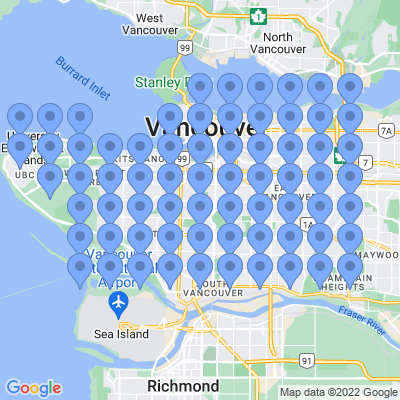

In [8]:
test_problem_points = utils.equidistant_points()
test_problem_points = list(filter(utils.is_on_land, test_problem_points))
print(len(test_problem_points))
display(utils.get_map(utils.vancouver_center, markers=[("blue", test_problem_points)], zoom=11))
distances = utils.straight_line_distance_matrix(test_problem_points, test_problem_points)

In [9]:
# build all the models we want to evaluate
all_models = {}

# models where we just consider our equidistant points as all sources and destinations
for num_hospitals in range(1, 10):
    num_locations = len(test_problem_points)
    num_patients = len(test_problem_points)
    A_leq, b_leq, A_eq, b_eq, bounds, integrality = p_median_constraint_matrix(num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations)
    c = p_median_objective_function(distances)
    solution = linprog(c, A_leq, b_leq, A_eq, b_eq, bounds=bounds, integrality=integrality)
    choices = p_median_interpret_solution(solution, num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations, output=False)

    print(f"Hospitals = {num_hospitals} | Choices = {choices} | Cost (avg distance in km)= {c.dot(solution.x)/num_patients}")
    # display(utils.display_solution(utils.vancouver_center, test_problem_points, choices, show_coverage=False))
    model_name = f"all_points_{num_hospitals}"
    all_models[model_name] = choices

Hospitals = 1 | Choices = [0] | Cost (avg distance in km)= 5.118056283437807
Hospitals = 2 | Choices = [4 5] | Cost (avg distance in km)= 3.50125482123748
Hospitals = 3 | Choices = [ 6 40 42] | Cost (avg distance in km)= 2.930294478356253
Hospitals = 4 | Choices = [ 8 27 38 39] | Cost (avg distance in km)= 2.5124638949091778
Hospitals = 5 | Choices = [11 26 41 43 45] | Cost (avg distance in km)= 2.1623216229096
Hospitals = 6 | Choices = [11 30 34 43 44 45] | Cost (avg distance in km)= 1.9604212238705105
Hospitals = 7 | Choices = [ 4 27 30 35 37 44 45] | Cost (avg distance in km)= 1.7891217239100883
Hospitals = 8 | Choices = [18 19 30 34 35 44 45 47] | Cost (avg distance in km)= 1.6522958591236137
Hospitals = 9 | Choices = [ 1 18 27 30 34 44 45 55 62] | Cost (avg distance in km)= 1.5602074694981256


In [10]:
# models where we optimize for response to senior populations
senior_sample = random.choices(utils.senior_population_points, weights=utils.senior_population_points_weights, k=len(test_problem_points))
senior_population_distances = utils.straight_line_distance_matrix(senior_sample, test_problem_points)
for num_hospitals in range(1, 10):
    num_locations = len(test_problem_points)
    patients = senior_sample
    num_patients = len(patients)
    A_leq, b_leq, A_eq, b_eq, bounds, integrality = p_median_constraint_matrix(num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations)
    c = p_median_objective_function(senior_population_distances)
    solution = linprog(c, A_leq, b_leq, A_eq, b_eq, bounds=bounds, integrality=integrality)
    choices = p_median_interpret_solution(solution, num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations, output=False)

    print(f"Hospitals = {num_hospitals} | Choices = {choices} | Cost (avg distance in km)= {c.dot(solution.x)/num_patients}")
    # display(utils.display_solution(utils.vancouver_center, test_problem_points, choices, show_coverage=False))
    model_name = f"senior_population_{num_hospitals}"
    all_models[model_name] = choices

Hospitals = 1 | Choices = [3] | Cost (avg distance in km)= 4.0170450141513685
Hospitals = 2 | Choices = [11 23] | Cost (avg distance in km)= 2.8384739103665733
Hospitals = 3 | Choices = [ 2 21 43] | Cost (avg distance in km)= 2.301931174666472
Hospitals = 4 | Choices = [11 20 25 43] | Cost (avg distance in km)= 1.9002781155432527
Hospitals = 5 | Choices = [ 6 11 25 38 43] | Cost (avg distance in km)= 1.6592697691948517
Hospitals = 6 | Choices = [ 6 11 25 27 38 43] | Cost (avg distance in km)= 1.478288740779996
Hospitals = 7 | Choices = [ 6 11 17 25 27 38 43] | Cost (avg distance in km)= 1.3110134477108673
Hospitals = 8 | Choices = [ 0  6 17 25 27 33 43 57] | Cost (avg distance in km)= 1.230425494820805
Hospitals = 9 | Choices = [ 0  6 17 25 27 30 33 43 57] | Cost (avg distance in km)= 1.1537329598439061


In [24]:
# optimize for response to regions with more than 40% of the population age > 65
senior_population_distances = utils.straight_line_distance_matrix(utils.high_senior_population_points, test_problem_points)
for num_hospitals in range(1, 10):
    num_locations = len(test_problem_points)
    patients = utils.high_senior_population_points
    num_patients = len(patients)
    A_leq, b_leq, A_eq, b_eq, bounds, integrality = p_median_constraint_matrix(num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations)
    c = p_median_objective_function(senior_population_distances)
    solution = linprog(c, A_leq, b_leq, A_eq, b_eq, bounds=bounds, integrality=integrality)
    choices = p_median_interpret_solution(solution, num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations, output=False)

    print(f"Hospitals = {num_hospitals} | Choices = {choices} | Cost (avg distance in km)= {c.dot(solution.x)/num_patients}")
    # display(utils.display_solution(utils.vancouver_center, test_problem_points, choices, show_coverage=False))
    model_name = f"high_senior_population_regions_{num_hospitals}"
    all_models[model_name] = choices

Hospitals = 1 | Choices = [1] | Cost (avg distance in km)= 4.199964524714249
Hospitals = 2 | Choices = [11 43] | Cost (avg distance in km)= 3.1063582899361806
Hospitals = 3 | Choices = [11 30 43] | Cost (avg distance in km)= 2.436182147668265
Hospitals = 4 | Choices = [11 30 39 43] | Cost (avg distance in km)= 1.8919637688823463
Hospitals = 5 | Choices = [14 15 30 39 47] | Cost (avg distance in km)= 1.4897252414789717
Hospitals = 6 | Choices = [14 15 25 30 39 47] | Cost (avg distance in km)= 1.275050543757983
Hospitals = 7 | Choices = [12 14 25 30 37 39 47] | Cost (avg distance in km)= 1.1049378256800466
Hospitals = 8 | Choices = [11 12 18 25 30 37 39 47] | Cost (avg distance in km)= 0.9794734833259497
Hospitals = 9 | Choices = [ 4 11 12 25 30 36 37 39 47] | Cost (avg distance in km)= 0.8794766093220303


In [11]:
# models where we optimize for a population density based sample
population_sample = random.choices(utils.all_points, weights=utils.all_points_weights, k=len(test_problem_points))
sample_distances = utils.straight_line_distance_matrix(population_sample, test_problem_points)
for num_hospitals in range(1, 10):
    num_locations = len(test_problem_points)
    num_patients = len(population_sample)
    A_leq, b_leq, A_eq, b_eq, bounds, integrality = p_median_constraint_matrix(num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations)
    c = p_median_objective_function(sample_distances)
    solution = linprog(c, A_leq, b_leq, A_eq, b_eq, bounds=bounds, integrality=integrality)
    choices = p_median_interpret_solution(solution, num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations, output=False)

    print(f"Hospitals = {num_hospitals} | Choices = {choices} | Cost (avg distance in km)= {c.dot(solution.x)/num_patients}")
    # display(utils.display_solution(utils.vancouver_center, test_problem_points, choices, show_coverage=False))
    model_name = f"population_density_sample_{num_hospitals}"
    all_models[model_name] = choices

Hospitals = 1 | Choices = [1] | Cost (avg distance in km)= 4.389763961858715
Hospitals = 2 | Choices = [19 36] | Cost (avg distance in km)= 3.105254621389466
Hospitals = 3 | Choices = [ 7 36 37] | Cost (avg distance in km)= 2.50373402329525
Hospitals = 4 | Choices = [ 7 30 33 37] | Cost (avg distance in km)= 2.0061023425132656
Hospitals = 5 | Choices = [27 30 33 37 45] | Cost (avg distance in km)= 1.7510535646764986
Hospitals = 6 | Choices = [18 27 30 33 37 45] | Cost (avg distance in km)= 1.554522877478679
Hospitals = 7 | Choices = [ 3 18 27 30 33 37 45] | Cost (avg distance in km)= 1.3680066324386913
Hospitals = 8 | Choices = [ 3 18 27 30 33 37 45 54] | Cost (avg distance in km)= 1.261585892775212
Hospitals = 9 | Choices = [ 1  5 18 27 30 33 37 45 54] | Cost (avg distance in km)= 1.1574447556899583


In [12]:
# models where we optimize for a population density based sample
# but now with more points in the sample
population_sample = random.choices(utils.all_points, weights=utils.all_points_weights, k=200)
sample_distances = utils.straight_line_distance_matrix(population_sample, test_problem_points)
for num_hospitals in range(1, 10):
    num_locations = len(test_problem_points)
    num_patients = len(population_sample)
    A_leq, b_leq, A_eq, b_eq, bounds, integrality = p_median_constraint_matrix(num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations)
    c = p_median_objective_function(sample_distances)
    solution = linprog(c, A_leq, b_leq, A_eq, b_eq, bounds=bounds, integrality=integrality)
    choices = p_median_interpret_solution(solution, num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations, output=False)

    print(f"Hospitals = {num_hospitals} | Choices = {choices} | Cost (avg distance in km)= {c.dot(solution.x)/num_patients}")
    # display(utils.display_solution(utils.vancouver_center, test_problem_points, choices, show_coverage=False))
    model_name = f"population_density_sample_many_points_{num_hospitals}"
    all_models[model_name] = choices

Hospitals = 1 | Choices = [13] | Cost (avg distance in km)= 4.226767555731808
Hospitals = 2 | Choices = [ 5 14] | Cost (avg distance in km)= 2.98678475235005
Hospitals = 3 | Choices = [ 4 27 35] | Cost (avg distance in km)= 2.4552874992588243
Hospitals = 4 | Choices = [ 4 21 33 47] | Cost (avg distance in km)= 2.052540832291319
Hospitals = 5 | Choices = [21 22 33 34 47] | Cost (avg distance in km)= 1.8010326134824868
Hospitals = 6 | Choices = [17 22 33 34 45 47] | Cost (avg distance in km)= 1.6126882530618558
Hospitals = 7 | Choices = [ 4 17 30 33 34 45 47] | Cost (avg distance in km)= 1.4405723352194146
Hospitals = 8 | Choices = [ 4  5 13 30 33 34 45 47] | Cost (avg distance in km)= 1.326988589563681
Hospitals = 9 | Choices = [ 5 13 18 20 30 33 34 45 47] | Cost (avg distance in km)= 1.2517983493966707


In [13]:
# models where we optimize for a balanced population sample between senior and regular populations
# 30% samples weighted by senior population proportions
# 70% samples weighed by total population proportions
n = 200
population_sample = random.choices(utils.all_points, weights=utils.all_points_weights, k=int(0.7*n))
senior_sample = random.choices(utils.senior_population_points, weights=utils.senior_population_points_weights, k=int(0.3*n))
balanced_sample = population_sample + senior_sample
sample_distances = utils.straight_line_distance_matrix(balanced_sample, test_problem_points)
for num_hospitals in range(1, 10):
    num_locations = len(test_problem_points)
    num_patients = len(balanced_sample)
    A_leq, b_leq, A_eq, b_eq, bounds, integrality = p_median_constraint_matrix(num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations)
    c = p_median_objective_function(sample_distances)
    solution = linprog(c, A_leq, b_leq, A_eq, b_eq, bounds=bounds, integrality=integrality)
    choices = p_median_interpret_solution(solution, num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations, output=False)

    print(f"Hospitals = {num_hospitals} | Choices = {choices} | Cost (avg distance in km)= {c.dot(solution.x)/num_patients}")
    # display(utils.display_solution(utils.vancouver_center, test_problem_points, choices, show_coverage=False))
    model_name = f"balanced_sample_{num_hospitals}"
    all_models[model_name] = choices

Hospitals = 1 | Choices = [1] | Cost (avg distance in km)= 4.139508255653781
Hospitals = 2 | Choices = [ 5 14] | Cost (avg distance in km)= 2.9502200072758127
Hospitals = 3 | Choices = [ 5 33 34] | Cost (avg distance in km)= 2.432112618436634
Hospitals = 4 | Choices = [ 6  7 33 37] | Cost (avg distance in km)= 2.058871930804998
Hospitals = 5 | Choices = [ 6 21 27 33 37] | Cost (avg distance in km)= 1.7551244652572313
Hospitals = 6 | Choices = [ 4 21 27 32 33 37] | Cost (avg distance in km)= 1.6138512262011968
Hospitals = 7 | Choices = [ 4 13 21 27 32 33 37] | Cost (avg distance in km)= 1.480346329673933
Hospitals = 8 | Choices = [13 18 21 27 32 33 34 40] | Cost (avg distance in km)= 1.3585291601478793
Hospitals = 9 | Choices = [ 5 13 18 25 32 33 34 40 47] | Cost (avg distance in km)= 1.2916906946122184


In [37]:
# attempt to improve the real world hospital networks with additional free standing hospitals 
real_hospitals = [
    (49.249519335110776, -123.01551932374011), # burnaby hospital
    (49.32068041315541, -123.06805419240101), # lions gate hospital
    (49.28080564825291, -123.12895387473844), # st pauls hospital
    (49.261203800748525, -123.12344345475546), # vancouver general hospital
    (49.24421560288513, -123.12412982629816), # bc childrens/womens hospital
    (49.26398297607463, -123.24584493126666), # ubc hospital
    (49.168342389356106, -123.14638191125505), # richmond hospital
]
n = 200
population_sample = random.choices(utils.all_points, weights=utils.all_points_weights, k=int(0.7*n))
senior_sample = random.choices(utils.senior_population_points, weights=utils.senior_population_points_weights, k=int(0.3*n))
balanced_sample = population_sample + senior_sample

points_with_fixed_points = real_hospitals + test_problem_points

sample_distances = utils.straight_line_distance_matrix(balanced_sample, points_with_fixed_points)
for num_free_standing in range(1, 5):
    num_locations = len(points_with_fixed_points)
    num_patients = len(balanced_sample)
    num_hospitals = len(real_hospitals) + num_free_standing
    num_fixed_point = len(real_hospitals)
    A_leq, b_leq, A_eq, b_eq, bounds, integrality = p_median_constraint_matrix(num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations, num_fixed_point=num_fixed_point)
    c = p_median_objective_function(sample_distances)
    solution = linprog(c, A_leq, b_leq, A_eq, b_eq, bounds=bounds, integrality=integrality)
    choices = p_median_interpret_solution(solution, num_hospitals=num_hospitals, num_patients=num_patients, num_locations=num_locations, output=False)

    print(f"Hospitals = {num_hospitals} | Choices = {choices} | Cost (avg distance in km)= {c.dot(solution.x)/num_patients}")
    # display(utils.display_solution(utils.vancouver_center, test_problem_points, choices, show_coverage=False))
    model_name = f"real_world_with_free_standing_{num_hospitals}"
    all_models[model_name] = choices

Hospitals = 8 | Choices = [ 0  1  2  3  4  5  6 26] | Cost (avg distance in km)= 2.1994201476877637
Hospitals = 9 | Choices = [ 0  1  2  3  4  5  6 10 50] | Cost (avg distance in km)= 1.9395658861748484
Hospitals = 10 | Choices = [ 0  1  2  3  4  5  6 10 11 50] | Cost (avg distance in km)= 1.736892181761384
Hospitals = 11 | Choices = [ 0  1  2  3  4  5  6 10 11 44 54] | Cost (avg distance in km)= 1.5413423260167582


In [47]:
# evaluate each model by each method
model_results = {}
for name, choices in all_models.items():
    # print(name, choices)
    if "real_world" in name:
        points_with_fixed_points = real_hospitals + test_problem_points
        hospitals = [points_with_fixed_points[h] for h in choices]
    else:
        hospitals = [test_problem_points[h] for h in choices]
    uniform_eval = utils.uniform_random_evaluate_solution(hospitals)
    population_eval = utils.population_sample_evaluate_solution(hospitals)
    senior_eval = utils.senior_population_sample_evaluate_solution(hospitals)
    balanced_eval = utils.balanced_sample_evaluate_solution(hospitals)
    model_results[name] = (uniform_eval, population_eval, senior_eval, balanced_eval)

In [55]:
print(f"Evaluation results")
print(f"model name => uniform sample, density sample, senior population sample, balanced sample")
for name, results in model_results.items():
    print(f"{name} => {[round(r[0],3) for r in results]}")

Evaluation results
model name => uniform sample, density sample, senior population sample, balanced sample
all_points_1 => [5.084, 4.365, 4.368, 4.354]
all_points_2 => [3.619, 3.221, 3.124, 3.2]
all_points_3 => [3.002, 2.926, 2.864, 2.958]
all_points_4 => [2.599, 2.559, 2.542, 2.539]
all_points_5 => [2.191, 2.074, 2.098, 2.099]
all_points_6 => [1.995, 1.994, 1.958, 1.974]
all_points_7 => [1.905, 1.778, 1.779, 1.772]
all_points_8 => [1.789, 1.64, 1.642, 1.615]
all_points_9 => [1.701, 1.613, 1.618, 1.625]
senior_population_1 => [5.528, 4.18, 4.237, 4.196]
senior_population_2 => [4.288, 2.916, 2.903, 2.91]
senior_population_3 => [3.353, 2.694, 2.606, 2.68]
senior_population_4 => [2.766, 2.219, 2.137, 2.215]
senior_population_5 => [2.332, 2.007, 1.932, 1.988]
senior_population_6 => [2.272, 1.894, 1.867, 1.868]
senior_population_7 => [2.108, 1.749, 1.722, 1.697]
senior_population_8 => [2.022, 1.538, 1.557, 1.55]
senior_population_9 => [1.747, 1.454, 1.483, 1.511]
population_density_sample_1

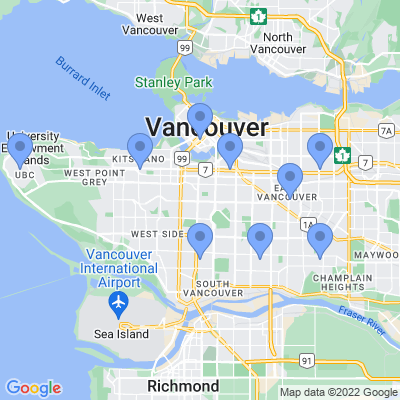

In [49]:
# probably the best result
# 9 hospitals, balanced
best_9_hospitals = [test_problem_points[h] for h in all_models["balanced_sample_9"]]
display(utils.get_map(utils.vancouver_center, markers=[('blue', best_9_hospitals)]))

all_points_9


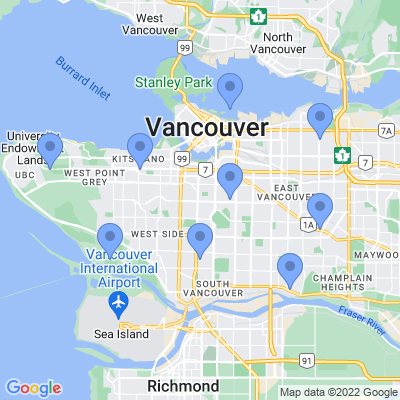

senior_population_9


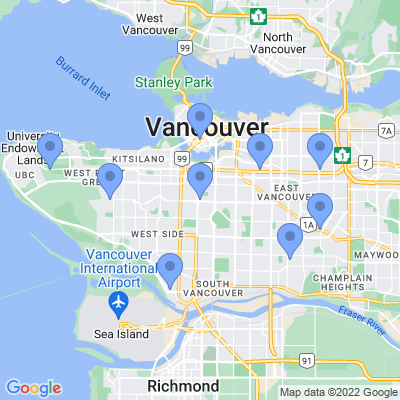

population_density_sample_9


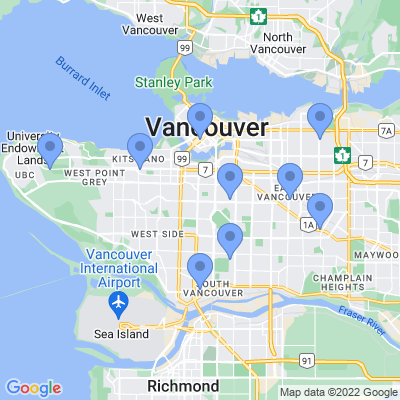

population_density_sample_many_points_9


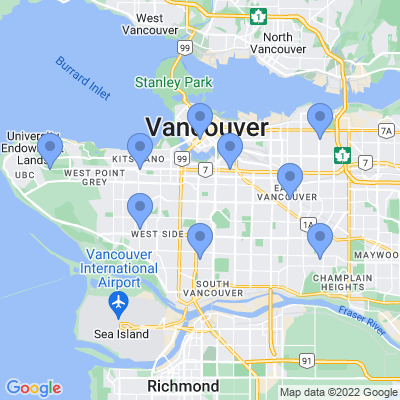

balanced_sample_9


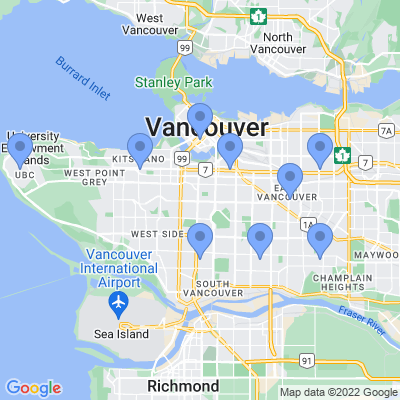

high_senior_population_regions_9


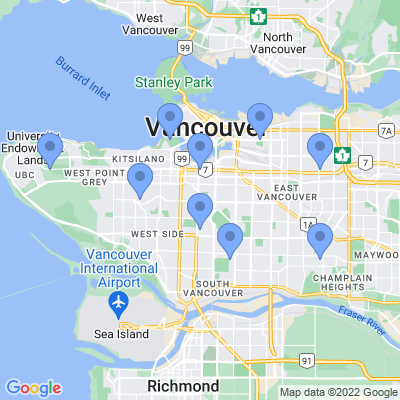

real_world_with_free_standing_9


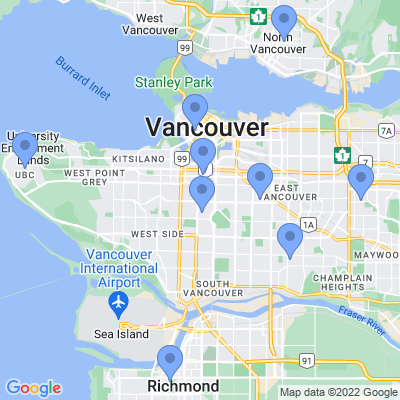

In [56]:
# other 9 hospital results
for name, choices in all_models.items():
    if "9" not in name:
        continue
    if "real_world" in name:
        points_with_fixed_points = real_hospitals + test_problem_points
        hospitals = [points_with_fixed_points[h] for h in choices]
    else:
        hospitals = [test_problem_points[h] for h in choices]
    print(name)
    display(utils.get_map(utils.vancouver_center, markers=[('blue', hospitals)]))

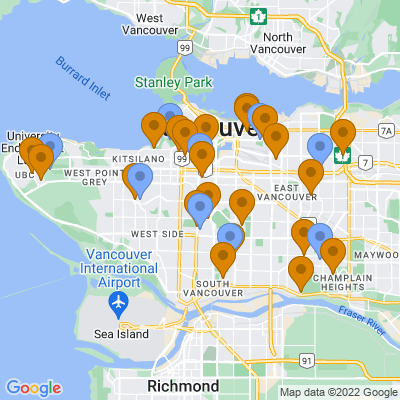

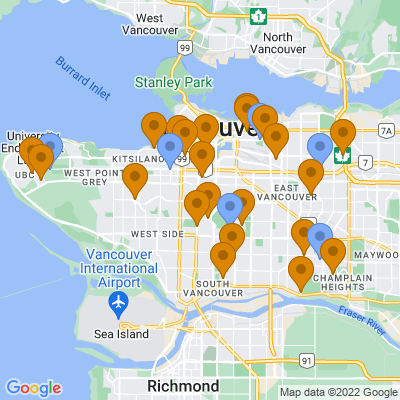

In [51]:
# high senior regions sample overlayed with the actual high senior population regions
high_senior_9 = [test_problem_points[h] for h in all_models["high_senior_population_regions_9"]]
display(utils.get_map(utils.vancouver_center, markers=[('blue', high_senior_9), ('orange', utils.high_senior_population_points)]))
high_senior_6 = [test_problem_points[h] for h in all_models["high_senior_population_regions_6"]]
display(utils.get_map(utils.vancouver_center, markers=[('blue', high_senior_6), ('orange', utils.high_senior_population_points)]))

all_points_6


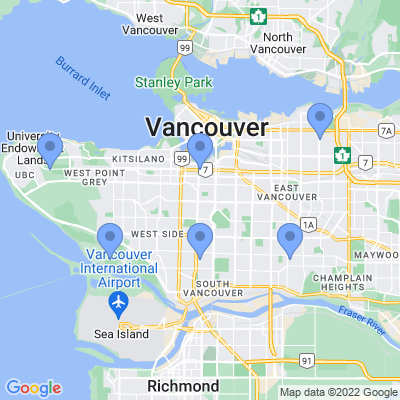

senior_population_6


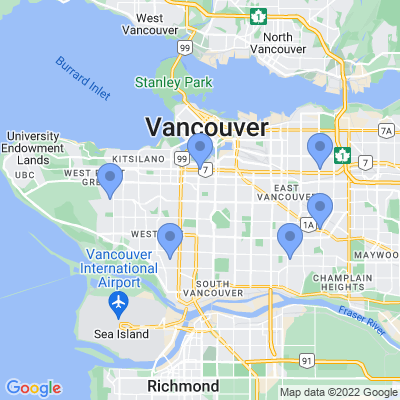

population_density_sample_6


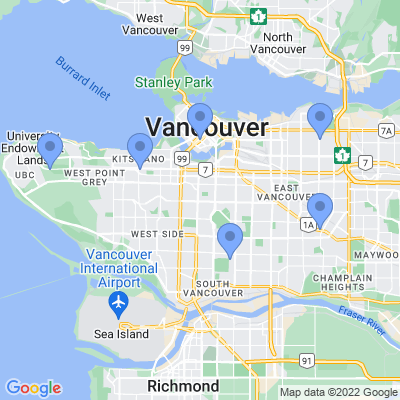

population_density_sample_many_points_6


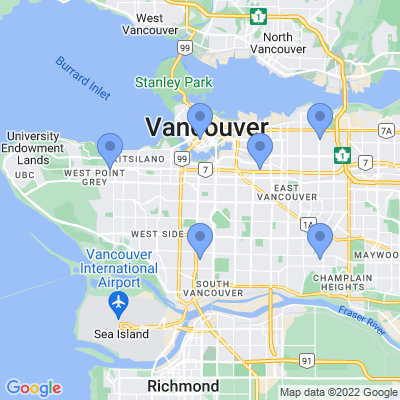

balanced_sample_6


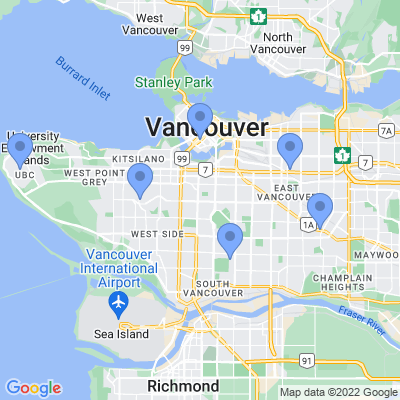

high_senior_population_regions_6


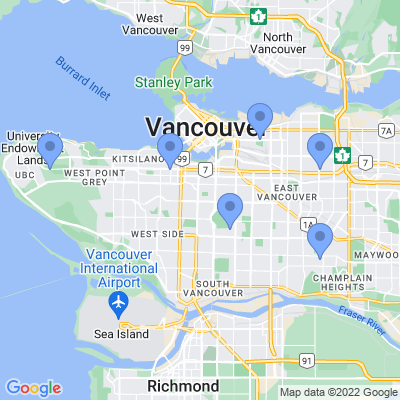

In [52]:
# all 6 hospital results
for name, choices in all_models.items():
    if "6" not in name:
        continue
    hospitals = [test_problem_points[h] for h in choices]
    print(name)
    display(utils.get_map(utils.vancouver_center, markers=[('blue', hospitals)]))

real vancouver hospital locations


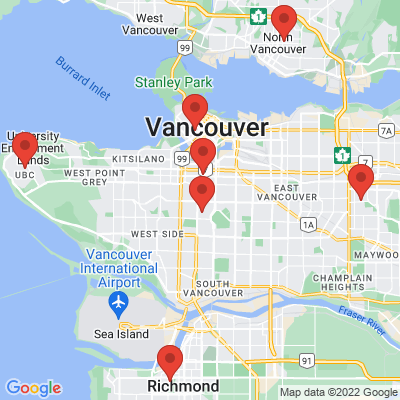

real_world_with_free_standing_8


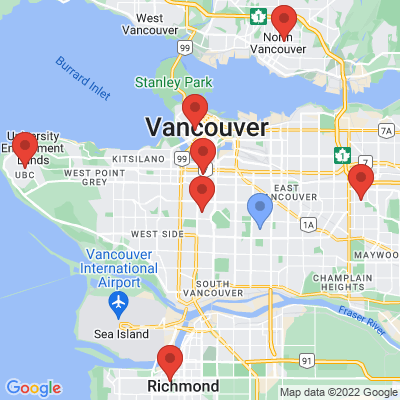

real_world_with_free_standing_9


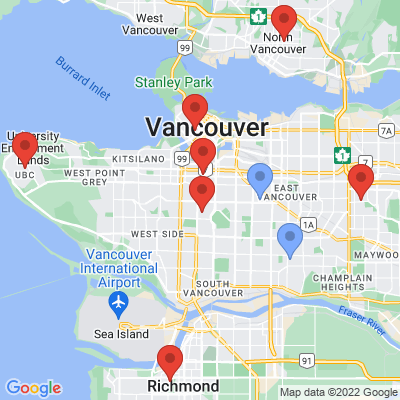

real_world_with_free_standing_10


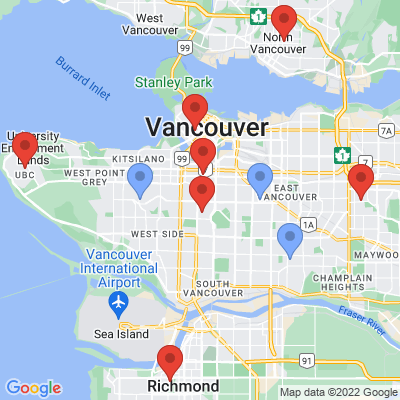

real_world_with_free_standing_11


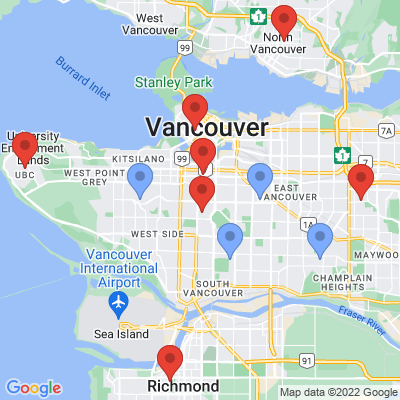

In [57]:
print("real vancouver hospital locations")
display(utils.get_map((49.249828, -123.125774), markers=[("red", real_hospitals)], zoom=11))
for name, choices in all_models.items():
    if "real_world" not in name:
        continue
    points_with_fixed_points = real_hospitals + test_problem_points
    hospitals = [points_with_fixed_points[h] for h in choices]
    print(name)
    display(utils.get_map(utils.vancouver_center, markers=[('blue', hospitals[len(real_hospitals):]), ('red', real_hospitals)]))

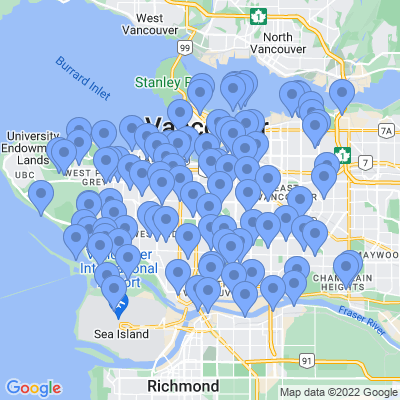

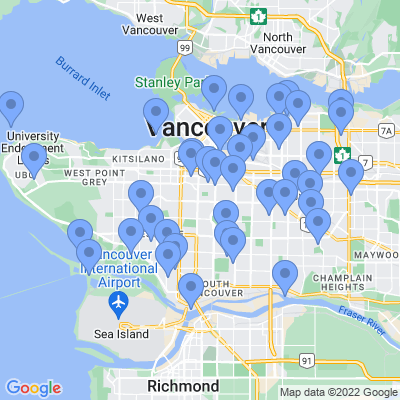

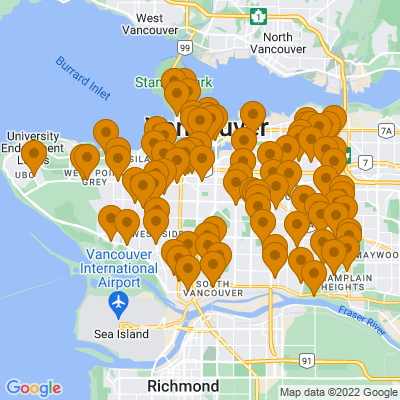

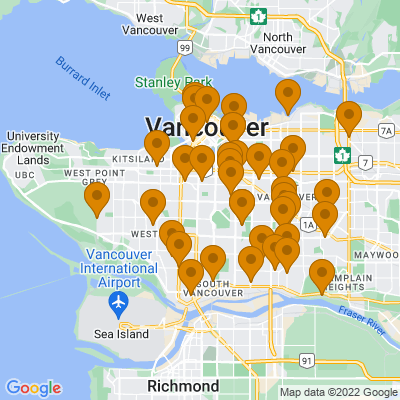

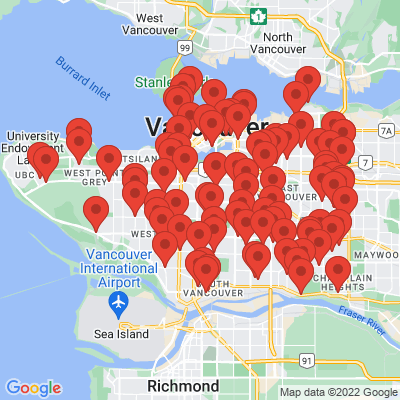

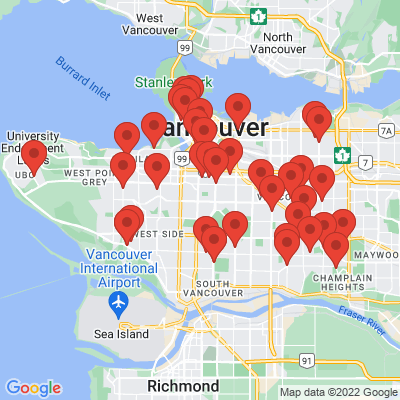

In [54]:
# uniform sample
display(utils.get_map(utils.vancouver_center, markers=[('blue', model_results["all_points_1"][0][1][:100])]))
display(utils.get_map(utils.vancouver_center, markers=[('blue', model_results["all_points_2"][0][1][:40])]))

# senior population sample
display(utils.get_map(utils.vancouver_center, markers=[('orange', model_results["all_points_1"][1][1][:100])]))
display(utils.get_map(utils.vancouver_center, markers=[('orange', model_results["all_points_2"][1][1][:40])]))

# population density sample
display(utils.get_map(utils.vancouver_center, markers=[('red', model_results["all_points_1"][2][1][:100])]))
display(utils.get_map(utils.vancouver_center, markers=[('red', model_results["all_points_2"][2][1][:40])]))